# Population firing rate
### 1. Overview

In recent experiments, people are able to manipulate *Dictyostelium*  population firing rate by changing two cell-cell coupling parameters- population density and extracellular fluid flow rate/ $cAMP_{e}$ dilution rate(Figure 7A). in a  In this notebook we are going to explore how different model tunes population firing rate with different densities and dilution rates  cells (Figure 7, below).

Because it is computationally costly to reproduce the full and high resolution heatmap for each model, this notebook offers two options for readers to play with different models.

1) Define a set of parameter pairs of interest (density, dilution rate) and visualize simulation traces of population-wide dynamics. 

2) Reproduce a heat map with less resolution. For example,define a parameter set with size 5 x 5 and visualize the heatmap. Note that the full simulation for a model could cost up to 2 hours on a 36-core computing node with parallel computing. Therefore it is not advised to use this notebook to run full, high resolution simulations. 
 
![Figure 7](POP_firing_rate.png)
<h5><center>Figure 7</center></h5>

#### Let's start by importing packages and setting up time scaling parameters

In [3]:
import numpy as np
from time import perf_counter 
from scipy.signal import find_peaks
import math

import matplotlib.pyplot as plt

import scipy.io
import pandas as pd

from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_pop_3var
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_pop
from Gregor2010_agent_and_pop_FUN import Gregor2010_pop
from Sgro2015_agent_and_pop_FUN import Sgro2015_pop
from Kamino2017_agent_and_pop_FUN import Kamino2017_pop

from NB_pop_functions import * 

# Normalization parameters
from NormParam import *

### 2. Experimental data 
#### import and plot experimental data
from [Sgro & Mehta 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352)

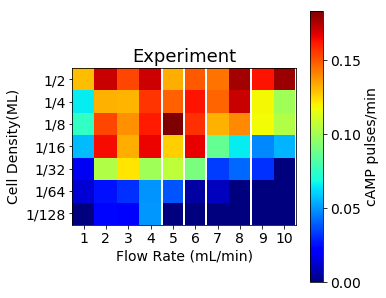

In [4]:
PopRateExp = np.array([[0.129660088,0.171190476,0.152777778,0.171016069,0.132986111,0.149074074,0.144444444,0.177170868,0.162719633,0.178571429],
[0.065434419,0.131937322,0.131658497,0.156811146,0.147619048,0.162799043,0.147368421,0.171820616,0.11875,0.1],
[0.075416667,0.152597403,0.138703704,0.161497326,0.183333333,0.157142857,0.132373581,0.139815266,0.117989418,0.103125],
[0.057236842,0.164138177,0.13287037,0.165909091,0.126666667,0.166827485,0.086222222,0.065789474,0.047584541,0.055555556],
[0.019047619,0.103693161,0.122423896,0.100198413,0.106683375,0.091592443,0.034122807,0.042105263,0.031818182,0],
[0.014285714,0.026428571,0.031578947,0.049938272,0.038095238,0.00625,0.010526316,0,0,0],
[0,0.02375,0.022222222,0.050595238,0,0,0,0,0,0]])

JExp = np.linspace(1,10, num=10) # np.array([0,1,2,4,6,8,10,15,16,20])
RhoExp = np.linspace(1,7, num=7) #  np.array([0.5,0.25,0.125,0.0625,0.03125,0.015625,0.0078125])

fig3 = plt.figure(figsize=(5, 5))
grid = plt.GridSpec(1,1, wspace=0.5, hspace=0.4)

ax0= fig3.add_subplot(grid[0,0])
ax0.set_xticks([0,1,2,3,4,5,6,7,8,9]); 
ax0.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontsize=14)
ax0.set_yticks([0,1,2,3,4,5,6,7]); 
ax0.set_yticklabels(['1/2','1/4','1/8','1/16','1/32','1/64','1/128'],fontsize=14)
ax0.set_title('Experiment', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax0.set_xlabel('Flow Rate (mL/min)', size=14)
ax0.set_ylabel('Cell Density(ML)', size=14)
heatmap = ax0.imshow(PopRateExp, cmap='jet') # cmap='jet'
x=[3.5,4.5,5.5,7.5,9.5]
[ax0.axvline(_x, color='white',linewidth=2) for _x in x]
# heatmap.set_clim(0,0.16)
cbar=fig3.colorbar(heatmap, ax=ax0,ticks=[0,0.05,0.1,0.15]);
cbar.ax.tick_params(labelsize = 14) 
cbar.set_label( 'cAMP pulses/min',size=14)

### 3. Matiel 1986
#### Set up parameters (from Table II in [Matiel & Goldbeter 1986](https://www.sciencedirect.com/science/article/pii/S0006349587832757?via%3Dihub) )

In [35]:
k1 = 0.036     # per min
k2 = 0.666    # per min
L1 = 10; L2 = 0.005 
c = 10;           # 0.15 ~ 50
lamda = 0.01; theta = 0.01; e =  1 ; q = 4000; sig= 0.6
v = 12; k = 4 # k prime in the paper
ki = 1.7; kt = 0.9; 
kc = 5.4; h = 5
Goldbeter3PopParam={'k1':k1,'k2':k2,'L1':L1,'L2':L2, 'c':c, 'lamda':lamda,\
            'theta':theta, 'e':e, 'q':q,'sig':sig, 'v':v, 'k':k, \
            'ki':ki,'kt':kt, 'kc':kc,'h':h}
dt=0.001; t_tot=25; t=list(np.arange(0,t_tot*Nt_Goldbeter,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

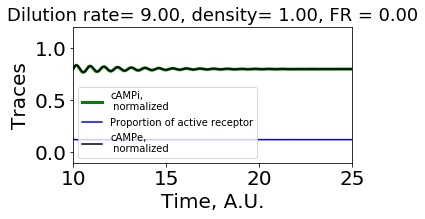

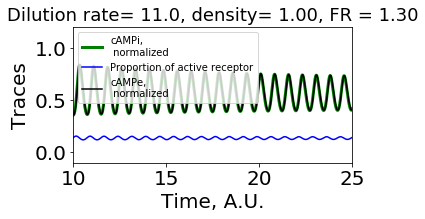

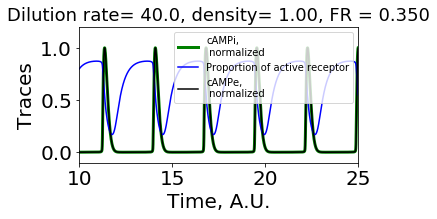

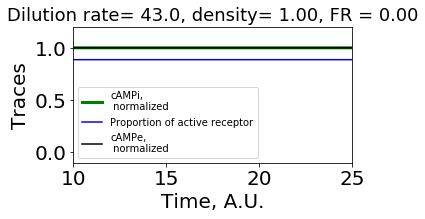

In [41]:
# cAMPe influx level. Default as 0. 
campExt_influx_trace=np.zeros(len(t))

# Define dilution/flow rate array
kc_arr = np.array([9,11,40,43]) # ([25])
# Define population density array
one_over_h_arr = np.array([1]) # ([2.4,1.5, 0.59])# cell density 
h_arr = 1/one_over_h_arr 

if_plt_traces = True # whether to plot individuial traces

for kc_temp in kc_arr:
    Goldbeter3PopParam['kc'] = kc_temp
    for h_temp in h_arr:
        Goldbeter3PopParam['h'] =  h_temp
        [t_plot_Goldbeter, b_trace, p_trace, g_trace] = Goldbeter_pop(Goldbeter3PopParam,dt,t,campExt_influx_trace)
        # Rescale time
        t_plot_Goldbeter = t_plot_Goldbeter/(Nt_Goldbeter)
        if if_plt_traces:
            later_portion = 0.2 # start count peaks after this X total simulation time
            b_trace_later=b_trace[math.floor(nSteps * later_portion):] # the later part of trace
            b_trace_later_norm = b_trace_later/np.amax(b_trace_later) # maximum trace amplitude normalized to 1 
            p_trace_later=p_trace[math.floor(nSteps * later_portion):]
            p_trace_later_norm = p_trace_later/np.amax(p_trace_later)
            g_trace_later=g_trace[math.floor(nSteps * later_portion):]
            g_trace_later_norm = g_trace_later/np.amax(g_trace_later)
            t_plot_Goldbeter_later = t_plot_Goldbeter[math.floor(nSteps * later_portion):]
    
            PkPos, PkProperties = find_peaks(b_trace_later, prominence=(5,1000))
    
            if len(PkPos) == 0:
                firing_rate = 0; height = 0
            else: 
                
                firing_rate = len(PkPos)/(t_tot*(1-later_portion))
                height = np.mean(PkProperties["prominences"])
    
            # plot the traces
            fig = plt.figure(figsize=(5,2.5)); grid = plt.GridSpec(1, 1,hspace= 0.3, wspace = 0.5)
            ax1= fig.add_subplot(grid[0, 0])
            ax1.plot(t_plot_Goldbeter_later,b_trace_later_norm, color = 'g', linewidth = 3, label = 'cAMPi,\n normalized')
            ax1.plot(t_plot_Goldbeter_later,p_trace_later, color ='b',label = 'Proportion of active receptor')
            ax1.plot(t_plot_Goldbeter_later,g_trace_later_norm, color ='k', label = 'cAMPe,\n normalized')
            ax1.set_xlim([10,25])
            ax1.set_ylim([-0.1,1.2])
            ax1.set_xlabel('Time, A.U.', fontsize=20); 
            ax1.set_ylabel('Traces',fontsize=20 )
            ax1.tick_params(grid_linewidth = 15, labelsize = 20)
            ax1.set_title('Dilution rate= '+ '{:#.3n}'.format(np.float64(kc_temp)) +
            ', density= '+'{:#.3n}'.format(np.float64(1/h_temp)) + 
                ', FR = '+'{:#.3n}'.format(np.float64(firing_rate)),
                          fontdict={'fontsize':18})
            leg = ax1.legend()

            # ax2= fig.add_subplot(grid[0, 1])
            # ax2.plot(t_plot_Goldbeter_later,b_trace_later_norm, color = 'g', linewidth = 3)
            # ax2.plot(t_plot_Goldbeter_later,p_trace_later, color ='b')
            # ax2.plot(t_plot_Goldbeter_later,g_trace_later_norm, color ='k')
            # ax2.set_xlim([10,20])
            # ax2.set_xlabel('Time')
            # ax2.set_ylabel('Normalized traces, A.U.')
            # ax2.set_title('Magnitude-normalized traces, zoomed in')

            plt.show()
            
        

### 4. Maeda 2004
#### Set up parameters (from supplementary in [Maeda et al 2004](https://science.sciencemag.org/content/304/5672/875/tab-figures-data) )

In [50]:
k1=2.0; k2=0.9; k3=2.5; k4=1.5; k5=0.6
k6=0.8; k7=1.0; k8=1.3; k9=0.3; k10=0.8
k11=0.7; k12=4.9; k13=23; k14=4.5
MaedaPopParam={'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,'k6':k6,\
            'k7':k7,'k8':k8,'k9':k9,'k10':k10,'k11':k11,'k12':k12,\
            'k13':k13,'k14':k14}
dt=0.001; t_tot=50; t=list(np.arange(0,t_tot*Nt_Maeda,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

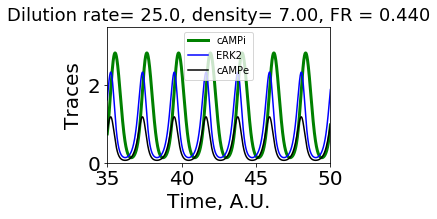

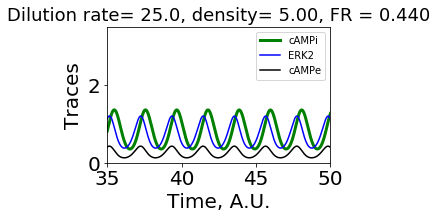

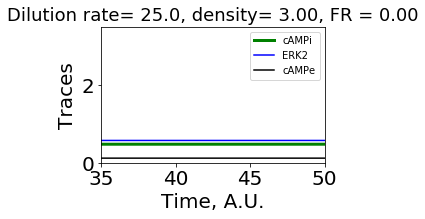

In [51]:
# cAMPe influx level. Default as 0. 
cAMPext_influx_trace=np.zeros(len(t))

# Define dilution/flow rate array
gamma_arr=np.array([25]) # ([15,25,35])# 
# Define population density array
rho_arr=np.array([7,5,3])# ([5]) #

if_plt_traces = True # whether to plot individuial traces

for gamma_temp in gamma_arr:
    for rho_temp in rho_arr:
        [t_plot_Maeda, cAMPi_trace, ERK2_trace,cAMPe_trace] = Maeda_pop(MaedaPopParam,dt,t,cAMPext_influx_trace, rho_temp, gamma_temp)
        t_plot_Maeda = t_plot_Maeda/Nt_Maeda
        if if_plt_traces:    
            later_portion = 0.5 # start count peaks after this X total simulation time
            # Meada 2004 model takes longer time to come to a euilibrium
            cAMPi_trace_later=cAMPi_trace[math.floor(nSteps * later_portion):] # the later part of trace   
            cAMPi_trace_later_norm = cAMPi_trace_later/np.amax(cAMPi_trace_later)
            ERK2_trace_later = ERK2_trace[math.floor(nSteps * later_portion):]
            ERK2_trace_later_norm = ERK2_trace_later/np.amax(ERK2_trace_later)
            cAMPe_trace_later=cAMPe_trace[math.floor(nSteps * later_portion):] # the later part of trace   
            cAMPe_trace_later_norm = cAMPe_trace_later/np.amax(cAMPe_trace_later)
            t_plot_Maeda_later = t_plot_Maeda[math.floor(nSteps * later_portion):]


            PkPos, PkProperties = find_peaks(cAMPi_trace_later, prominence=(0.01,2000))
            if len(PkPos) == 0:
                firing_rate = 0; height = 0
            else: 
                firing_rate = len(PkPos)/(t_tot*(1-later_portion))
                height = np.mean(PkProperties["prominences"])

            # plot traces
            fig = plt.figure(figsize=(10,2.5)); grid = plt.GridSpec(1, 2,hspace= 0.3, wspace = 0.5)
            ax1= fig.add_subplot(grid[0, 0])
            ax1.plot(t_plot_Maeda_later,cAMPi_trace_later, color = 'g', linewidth = 3, label = 'cAMPi')
            ax1.plot(t_plot_Maeda_later,ERK2_trace_later, color ='b',label = 'ERK2')
            ax1.plot(t_plot_Maeda_later,cAMPe_trace_later, color ='k', label = 'cAMPe')
            ax1.set_xlim([35,50])
            ax1.set_ylim([0,3.5])
            ax1.set_xlabel('Time, A.U.', fontsize=20); 
            ax1.set_ylabel('Traces',fontsize=20 )
            ax1.tick_params(grid_linewidth = 15, labelsize = 20)
            ax1.set_title('Dilution rate= '+ '{:#.3n}'.format(np.float64(gamma_temp)) +
            ', density= '+'{:#.3n}'.format(np.float64(rho_temp)) + 
                ', FR = '+'{:#.3n}'.format(np.float64(firing_rate)),
                         fontdict={'fontsize':18})
            leg = ax1.legend()

            # ax2= fig.add_subplot(grid[0, 1])
            # ax2.plot(t_plot_Maeda_later,cAMPi_trace_later_norm, color = 'g', linewidth = 3)
            # ax2.plot(t_plot_Maeda_later,ERK2_trace_later_norm, color ='b')
            # ax2.plot(t_plot_Maeda_later,cAMPe_trace_later_norm, color ='k')
            # ax2.set_xlim([20,30])
            # ax2.set_xlabel('Time')
            # ax2.set_ylabel('Normalized trace, A.U.')
            # ax2.set_title('Magnitude-normalized traces, zoomed in')

            plt.show()


### 5. Gregor 2010 
#### Set up parameters

In [56]:
Amax=20;  Abas=0.4 # uM
w=2*math.pi/6 # min-1
Vc=1.1e-9 # ml
St=1.33 # cm2
Sc=1.3e-6 # cm2
K=0.0004 # uM, 400 pM
c_sec= 3.6 # min-1
c_excite=1.01 # min-1
Nc=100 # Num of cells
Vt = 1 #chamber size ml
eta = 0.002 # noise strength

rho = 1/12 # density, what percentage of a monolayer
k = 5 # flow rate, ml/min
GregorPopParam={'Amax':Amax,'Abas':Abas,'w':w,'Vc':Vc,'St':St,'Sc':Sc,'K':K,\
                'c_sec':c_sec,'c_excite':c_excite,'eta':eta, \
                'Nc':Nc, 'rho':rho, 'Vt':Vt,'k':k}
dt=0.001; t_tot=25; t=list(np.arange(0,t_tot*Nt_Gregor,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

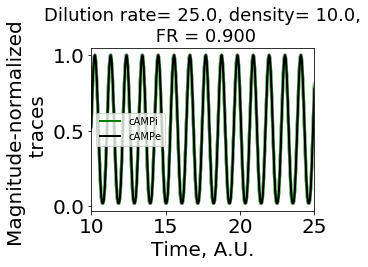

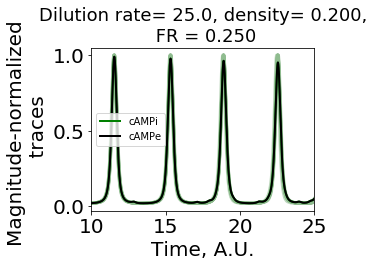

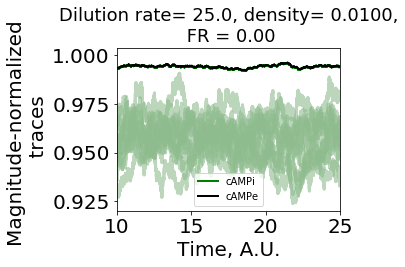

In [58]:
# cAMPe influx level. By default is 0.
cAMPext_influx_trace=np.zeros(len(t))
time_separation = 0

# Define dilution/flow rate array
k_arr=np.array([25]) # ([0.5,25,50,100]) 
# Define population density array
rho_arr=np.array([10,0.2,0.01]) # ([0.2])

if_plt_traces = True # whether to plot individuial traces
SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for k_temp in k_arr:
    GregorPopParam['k'] = k_temp
    for rho_temp in rho_arr:
        GregorPopParam['rho'] = rho_temp
        [t_plot_Gregor,  cAMPi, thetai,cAMPe] = Gregor_pop(GregorPopParam,dt,
                                                           t, cAMPext_influx_trace, time_separation)
        
        t_plot_Gregor = t_plot_Gregor/(Nt_Gregor)
        if if_plt_traces:      
            
            cAMPi_mean= np.mean(cAMPi,axis = 0)
            thetai_mean = np.mean(thetai,axis = 0)
            
            later_portion = 0.2 # start count peaks after this X total simulation time
            cAMPi_later = cAMPi[:,math.floor(nSteps * later_portion):] 
            cAMPi_later_norm = cAMPi_later/np.amax(cAMPi_later)
            
            cAMPi_mean_later=cAMPi_mean[math.floor(nSteps * later_portion):] 
            cAMPi_mean_later_norm = cAMPi_mean_later/np.amax(cAMPi_mean_later)
            
            thetai_mean_later=thetai_mean[math.floor(nSteps * later_portion):] 
            thetai_mean_later_norm = thetai_mean_later/np.amax(thetai_mean_later)
            
            cAMPe_later=cAMPe[math.floor(nSteps * later_portion):] 
            cAMPe_later_norm = cAMPe_later/np.amax(cAMPe_later)
            
            t_plot_Gregor_later = t_plot_Gregor[math.floor(nSteps * later_portion):]
            
            PkPos, PkProperties = find_peaks(cAMPi_mean_later, prominence=(0.5,30))
            if len(PkPos) == 0:
                firing_rate = 0; height = 0
            else: 
                firing_rate = len(PkPos)/(t_tot*(1-later_portion))
                height = np.mean(PkProperties["prominences"])
            
            # Plot selected traces
            plot_POP_oscillation_FR(k_temp, rho_temp, firing_rate, t_plot_Gregor_later,cAMPi_mean_later_norm,'cAMPi',
                            0,'thetai', cAMPe_later_norm,[10,25], cAMPi_later_norm, SC_traces_idx )         

### 6. Sgro 2015 
#### Set up parameters
from [Sgro & Mehta 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352)

In [20]:
e=0.1 # excitability
sigma = 0.15 # noise strength
tauA=0.09; tauR=tauA/e; g=0.5
N = 100; rho = 10**(-3.5); j = 0.5
SgroPopParam={'e':e,'tauA':tauA,'tauR':tauR,'g':g,'c0':1.2,'sigma':sigma,'N':N,\
            'a':0.058,'alpha0':800,'alpha_pde':1000,'Kd':1e-5,'S':1e6,\
            'Nt':27,'Na':3.5,'offset_A':1.5,'flux_thrs':0, 'rho': rho,'j': j}

dt=0.001 ; t_tot=25*Nt_Sgro;t=list(np.arange(0,t_tot,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

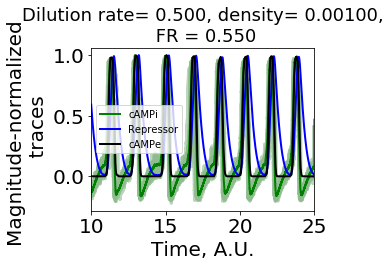

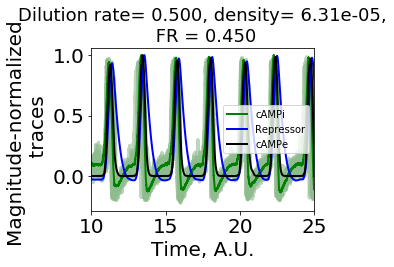

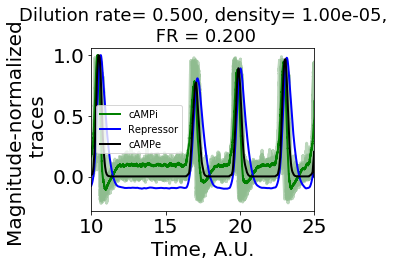

In [24]:
# cAMPe influx level. By default is 0.
cAMPext_influx_trace=np.zeros(len(t))

# Define dilution/flow rate array
j_arr=np.array([0.5]) 
# Define population density array
rho_arr=np.array([10**(-3),10**(-4.2),10**(-5)])

if_plt_traces = True # whether to plot individuial traces
SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for j_temp in j_arr:
    SgroPopParam['j'] = j_temp
    for rho_temp in rho_arr:
        SgroPopParam['rho'] = rho_temp
        [t_plot_Sgro, A_plot,  R_orig, R_plot, cAMPe] = Sgro_pop(SgroPopParam,dt,
                                                              t,cAMPext_influx_trace)
        
        t_plot_Sgro = t_plot_Sgro/(Nt_Sgro)
        if if_plt_traces:      
            
            A_plot_mean= np.mean(A_plot,axis = 0)
            R_plot_mean = np.mean(R_plot,axis = 0)
            
            later_portion = 0.2 # start count peaks after this X total simulation time
            A_plot_later = A_plot[:,math.floor(nSteps * later_portion):] 
            A_plot_later_norm = A_plot_later/np.amax(A_plot_later)
            
            A_plot_mean_later=A_plot_mean[math.floor(nSteps * later_portion):] 
            A_plot_mean_later_norm = A_plot_mean_later/np.amax(A_plot_mean_later)
            
            R_plot_mean_later=R_plot_mean[math.floor(nSteps * later_portion):] 
            R_plot_mean_later_norm = R_plot_mean_later/np.amax(R_plot_mean_later)
            
            cAMPe_later=cAMPe[math.floor(nSteps * later_portion):] 
            cAMPe_later_norm = cAMPe_later/np.amax(cAMPe_later)
            
            t_plot_Sgro_later = t_plot_Sgro[math.floor(nSteps * later_portion):]
            
            PkPos, PkProperties = find_peaks(A_plot_mean_later, prominence=(0.4,2))
            if len(PkPos) == 0:
                firing_rate = 0; height = 0
            else: 
                firing_rate = len(PkPos)/(t_tot/Nt_Sgro*(1-later_portion))
                height = np.mean(PkProperties["prominences"])
            
            # Plot selected traces
            plot_POP_oscillation_FR(j_temp, rho_temp, firing_rate, t_plot_Sgro_later,
                                    A_plot_mean_later_norm,'cAMPi',
                                    R_plot_mean_later_norm,'Repressor', 
                                    cAMPe_later_norm,[10,25], A_plot_later_norm, SC_traces_idx )  

### 7. Kamino 2017
#### Set up parameters

In [5]:
tau=1.5; n=2; K=4; kt=2; delta=0.01
gamma=3 # cAMPe dilution/degradation rate 
rho= 1 # population density
KaminoPopParam={'tau':tau,'n':n,'K':K,'kt':kt,'delta':delta,\
               'gamma':gamma,'rho':rho}
dt=0.0001; t_tot = 25; t=list(np.arange(0,t_tot*Nt_Kamino,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

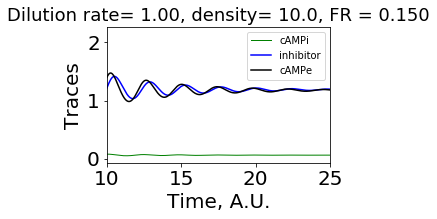

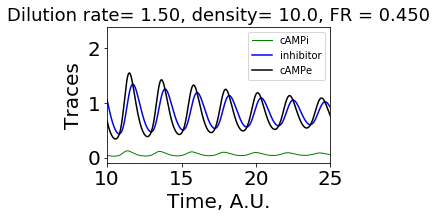

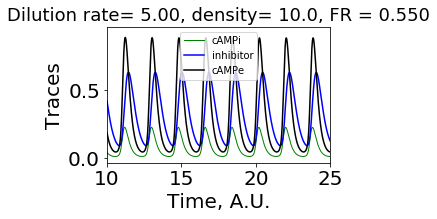

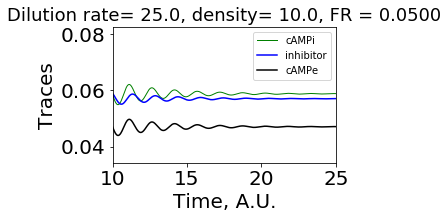

In [7]:
# cAMPe influx level. Default is 0. 
cAMPext_influx_trace=np.zeros(len(t))

gamma_arr = np.array([1, 1.5,5, 25])# ([25]) # 
rho_arr = np.array([10]) # np.array([20,15,10]) # ([10])
if_plt_traces = True # whether to plot individuial traces

for gamma_temp in gamma_arr:
    KaminoPopParam['gamma'] = gamma_temp
    for rho_temp in rho_arr:
        KaminoPopParam['rho'] = rho_temp
        [t_plot_Kamino, y_trace, x_trace, z_trace] = Kamino_pop(KaminoPopParam,dt,t,cAMPext_influx_trace)
        t_plot_Kamino = t_plot_Kamino/(Nt_Kamino)
        if if_plt_traces:
            later_portion = 0.2 # start count peak after this X total simulation time
            y_trace_later=y_trace[math.floor(nSteps * later_portion):] # the later part of trace
            y_trace_later_norm = y_trace_later/np.amax(y_trace_later)
            x_trace_later=x_trace[math.floor(nSteps * later_portion):] 
            x_trace_later_norm = x_trace_later/np.amax(x_trace_later)
            z_trace_later=z_trace[math.floor(nSteps * later_portion):] 
            z_trace_later_norm = z_trace_later/np.amax(z_trace_later)
            t_plot_Kamino_later = t_plot_Kamino[math.floor(nSteps * later_portion):]

            PkPos, PkProperties = find_peaks(y_trace_later, prominence=(0.02,100))
            if len(PkPos) == 0:
                firing_rate = 0; height = 0
            else: 
                firing_rate = len(PkPos)/(t_tot*(1-later_portion))
                height = np.mean(PkProperties["prominences"])

            # check simulation traces
            fig = plt.figure(figsize=(10,2.5)); grid = plt.GridSpec(1, 2,hspace= 0.3,wspace = 0.5)
            ax1= fig.add_subplot(grid[0, 0])
            ax1.plot(t_plot_Kamino_later,y_trace_later, color = 'g', linewidth = 1, label = 'cAMPi')
            ax1.plot(t_plot_Kamino_later,x_trace_later, color ='b',label = 'inhibitor')
            ax1.plot(t_plot_Kamino_later,z_trace_later, color ='k', label = 'cAMPe')
            ax1.set_xlim([10,25])
            # ax1.set_ylim([0,3.5])
            ax1.set_xlabel('Time, A.U.', fontsize=20); 
            ax1.set_ylabel('Traces',fontsize=20 )
            ax1.tick_params(grid_linewidth = 15, labelsize = 20)
            ax1.set_title('Dilution rate= '+ '{:#.3n}'.format(np.float64(gamma_temp)) +
            ', density= '+'{:#.3n}'.format(np.float64(rho_temp)) + 
                ', FR = '+'{:#.3n}'.format(np.float64(firing_rate)),
                         fontdict={'fontsize':18})
            leg = ax1.legend()
            # ax2= fig.add_subplot(grid[0, 1])
            # ax2.plot(t_plot_Kamino_later,x_trace_later_norm, color = 'g', linewidth = 3)
            # ax2.plot(t_plot_Kamino_later,y_trace_later, color ='b')
            # ax2.plot(t_plot_Kamino_later,z_trace_later_norm, color ='k')
            # ax2.set_xlim([30,50])
            # ax2.set_xlabel('Time')
            # ax2.set_ylabel('Normalized traces, A.U.')
            # ax2.set_title('Normalized traces, zoomed in')

            plt.show()
            
